# Interaction with the World Homework (#3)
Python Computing for Data Science (c) J Bloom, UC Berkeley 2018

Due Tuesday 2pm, Feb 20, 2018

# 1) Monty: The Python Siri

Let's make a Siri-like program (call it Monty!) with the following properties:
   - record your voice command
   - use a webservice to parse that sound file into text
   - based on what the text, take three different types of actions:
       - send an email to yourself
       - do some math
       - tell a joke

So for example, if you say "Monty: email me with subject hello and body goodbye", it will email you with the appropriate subject and body. If you say "Monty: tell me a joke" then it will go to the web and find a joke and print it for you. If you say, "Monty: calculate two times three" it should response with printing the number 6.

Hint: you can use speed-to-text apps like Houndify (or, e.g., Google Speech https://cloud.google.com/speech/) to return the text (but not do the actions). You'll need to sign up for a free API and then follow documentation instructions for using the service within Python. 

In [1]:
# Populate our namespace
import pyaudio
import numpy as np
import wave
#from houndify import * 
import monty_key
#pip install word2number #this is a package used to convert strings of written numbers to ints
from word2number import w2n

import houndify #class provided by houndify in order to interface with thier speach to text engine
import time
from bs4 import BeautifulSoup
from urllib.request import urlopen
import json




In [2]:
#We define a function to record audio, we are recycling code from lecture

def record_audio(length_of_recording ,file_name='' ,path = '',sample_rate = 16000):
    """
    Takes input: 
    
    length_of_recording: the desired lenth in seconds of the recording
    path: the path for the .wav file to be saved, if not specified, it will 
    be saved in the current directory
    file_name: the name of the .wav file to be saved, if not specified, it will
    be named "new_wave.wav"
    
    sample_rate: Must be either 8kHz or 16kHz. If not specified, defaults to 16kHz
    
    Records audio from the building mic with sample rate of 44.1kHz for user defined length of time
    A .wav file is then 
    """
    
    #Check if user gave path/file name, if not, then given defaults
    if len(file_name) != 0:    
        WAVE_OUTPUT_FILENAME = path + file_name + '.wav'        
    else:
        WAVE_OUTPUT_FILENAME = path + "new_wave.wav"
        
    chunk = 1024
    
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = sample_rate
    RECORD_SECONDS = length_of_recording                
    p = pyaudio.PyAudio()
    print("* Starting recording")
    stream = p.open(format = FORMAT,
        channels = CHANNELS,
        rate = RATE,
        input = True,
        frames_per_buffer = chunk)
    all = []
    #for i in range(0, int(RATE / chunk * RECORD_SECONDS)):
    try:
        while True:
            data = stream.read(chunk)
            all.append(data)
    except:
        KeyboardInterrupt
            
    print("* done recording")
    stream.close()
    p.terminate()
    
    data = b"".join(all)
    wf = wave.open(WAVE_OUTPUT_FILENAME, "wb")
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(data)
    wf.close()
    
    return data
    


In [3]:
def convert_to_text(file_name):
    """
    Modified code provided by Houndify that 
    uses the Houndify class to connect to thier
    speach to text engine to convert provided .wav files to 
    text.
    
    Inputs:
    file_name: name of .wav file (and path if not in same directory) to converted
    to text
    
    Returns:
    words: the text returned by Houndify parsed into a list of words
    
    """

    #fname = 'houndify_python3_sdk_1.0.0/test_audio/whatistheweatherthere.wav'
    file_name = file_name + '.wav'
    CLIENT_ID = monty_key.Client_ID
    CLIENT_KEY = monty_key.Client_Key
    AUDIO_FILE = file_name
    BUFFER_SIZE = 512

    

    client = houndify.StreamingHoundClient(CLIENT_ID, CLIENT_KEY, "monty")
    

    #checks to make sure the audio meets the correct criteria to use Houndify
    audio = wave.open(AUDIO_FILE)
    if audio.getsampwidth() != 2:
      print("%s: wrong sample width (must be 16-bit)" % file_name)
    if audio.getframerate() != 8000 and audio.getframerate() != 16000:
      print("%s: unsupported sampling frequency (must be either 8 or 16 khz)" % file_name)
    if audio.getnchannels() != 1:
      print("%s: must be single channel (mono)" % file_name)

    client.setSampleRate(audio.getframerate())
    client.start()

    while True:
      samples = audio.readframes(BUFFER_SIZE)
      if len(samples) == 0: break
      if client.fill(samples): break
      time.sleep(0.032) # simulate real-time so we can see the partial transcripts
    
    results = client.finish() # returns either final response or error
    
    #print(results)
    
    text = results['AllResults'][0]['RawTranscription']#['SpokenResponse']
    words = text.split()
    return words


In [4]:
def get_joke():
    base_url = "https://api.whatdoestrumpthink.com/api/v1/quotes/random"
    url = base_url
    json_result = json.loads(urlopen(url).read().decode("UTF-8"))
    joke = 'A quote from the President of the United States: \n' + json_result['message']
    return joke

In [6]:
def do_task(words):
    print(words)
    email_key = ['mail','email','send','subject','body']
    joke_key = ['joke']
    math_operations = {'times': '*',
                       'multiply':'*', 
                       'add':'+',
                       'plus':'+',
                       'sum':'+',
                       'subtract':'-',
                       'minus':'-',
                       'divide':'/',
                       'divided':'/',
                       'negative':'-',
                       'point':'.'}

    numbers = list()

    if any(keyword in words for keyword in email_key):
        print('send email')
    elif any(keyword in words for keyword in joke_key):
        joke = get_joke()
        return joke
    elif any(keyword in words for keyword in math_operations.keys()):
        print('Let\'s do some math!')
        for word in words:
            for key in math_operations.keys():
                if word == key:
                    operation = math_operations[word]
                    good_key = key
                    
        for word in words:        
            try: 
                temp_number = w2n.word_to_num(word)
                numbers.append(temp_number)
            except ValueError:
                
                if word == good_key:
                    temp_number = operation
                    numbers.append(temp_number)
                #else:
                #    temp_number = 0

            

        
        new_numbers = list()
        
        for iNumber in range(1,len(numbers)):
            
            if type(numbers[iNumber-1]) == int and type(numbers[iNumber]) == int:
                #print('----- both ints -----')
                #print('index: ', iNumber-1, ' value: ', numbers[iNumber-1])
                #print('index: ', iNumber, ' value: ', numbers[iNumber])
                new_numbers.append(numbers[iNumber-1])
                new_numbers.append('+')
            elif type(numbers[iNumber-1]) == int and type(numbers[iNumber])== str:
                #print('----- int and str -----')
                #print('index: ', iNumber-1, ' value: ', numbers[iNumber-1])
                #print('index: ', iNumber, ' value: ', numbers[iNumber])
                new_numbers.append(numbers[iNumber-1])
            elif type(numbers[iNumber-1]) == str and type(numbers[iNumber])== int:
                #print('----- str and int -----')
                #print('index: ', iNumber-1, ' value: ', numbers[iNumber-1])
                new_numbers.append(numbers[iNumber-1])
            #else:
            #    print('--- this was called?---')
            #    new_numbers.append(numbers[iNumber])
        new_numbers.append(numbers[-1])
        numbers_str = ''.join(map(str, new_numbers))
        answer = eval(numbers_str)
        return_str = 'The Anwer is: ' +str(answer)
        
        #print(numbers)
        #print(operation)
        #print(eval(str(numbers[0])+ operation +str(numbers[1])))
        return return_str
    
    

In [8]:
file_name = 'joke'
time_for_recording = 3
data = record_audio(time_for_recording, file_name )
#time.sleep(time_for_recording)
words = convert_to_text(file_name)
return_str = do_task(words)
print(return_str)



* Starting recording
* done recording
['what', 'is', 'ten', 'times', 'point', 'five']
Let's do some math!
The Anwer is: 15


In [244]:

numbers = ['what', 'is', 'two', 'hundred', 'divided', 'by', 'five']
my_lst_str = ' '.join(map(str, numbers))
print(my_lst_str)
print(w2n.word_to_num(my_lst_str))

what is two hundred divided by five
205


# 2) Write a program that identifies musical notes from sound (AIFF) files. 

  - Run it on the supplied sound files (12) and report your program’s results. 
  - Use the labeled sounds (4) to make sure it works correctly. The provided sound files contain 1-3 simultaneous notes from different organs.
  - Save copies of any example plots to illustrate how your program works.
  
  https://piazza.com/berkeley/spring2018/ay250class13410/resources -> Homeworks -> hw3_sound_files.zip

In [1]:
#pip install SoundFile 
import soundfile as sf
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from scipy import fftpack as fft
from os import listdir
import os
import seaborn as sns
import scipy.signal as signal

sns.set_style('darkgrid')



file = 'data/sound_files/C4+A4_PopOrgan.aif'
data, samplerate = sf.read(file, dtype='int32')


mono_data = data[:,0] + data[:,1]

"""FFT_left = fft.rfft(data[:,0])
FFT_right = fft.rfft(data[:,1])

plt.plot(data)
plt.plot(freqs,np.abs(FFT_left)**2)
plt.plot(freqs,np.abs(FFT_right)**2)
plt.xlim(20,1000)
plt.xscale('log')
plt.show()
"""

"FFT_left = fft.rfft(data[:,0])\nFFT_right = fft.rfft(data[:,1])\n\nplt.plot(data)\nplt.plot(freqs,np.abs(FFT_left)**2)\nplt.plot(freqs,np.abs(FFT_right)**2)\nplt.xlim(20,1000)\nplt.xscale('log')\nplt.show()\n"

Hints: You’ll want to decompose the sound into a frequency power spectrum. Use a Fast Fourier Transform. Be care about “unpacking” the string hexcode into python data structures. The sound files use 32 bit data. Play around with what happens when you convert the string data to other integer sizes, or signed vs unsigned integers. Also, beware of harmonics.

<IPython.core.display.Javascript object>


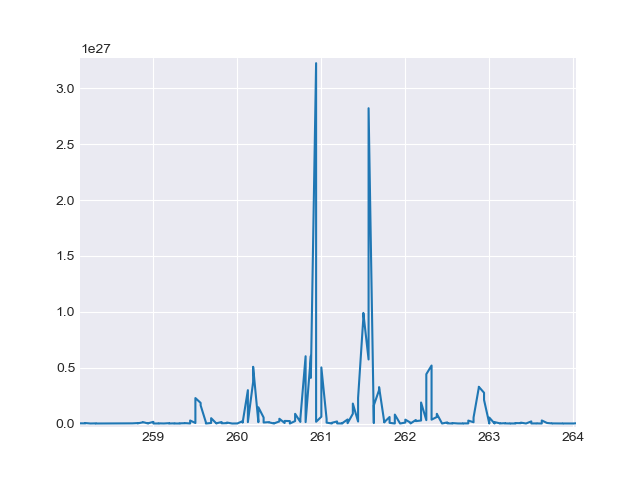

In [26]:
FFT_mono = fft.rfft(mono_data)
plt.plot(freqs,FFT_mono**2)
plt.show()


In [12]:
def return_note_name(step):
    notes = ['A','A#','B','C','C#','D','D#','E','F','F#','G','G#']
    octive_number = step // 12
    note = step % 12
    return notes[note]+str(octive_number)


def convert_to_half_steps(freq):
    C0 = 16.35 #Hz, defined from the standard A440 tuning
    
    half_step = np.round(12*np.log2(freq/C0))
    half_step = half_step.astype(np.int16)
    return half_step




In [13]:
#Import all the files in our directory

path = 'data/sound_files/'

data_files = {}

for file in listdir(path):
    filename, file_extension = os.path.splitext(file)
    if file_extension == '.aif':
        data, fs = sf.read(path+file, dtype='int32')
        data_files[file] = [fs,data[:,0]+data[:,1]] #add the sample rate and the data to a dictionary, also make the stereo data mono
    

    
    
N = len(data)
freqs = fft.rfftfreq(N, d = 1/samplerate)    
    
    


In [29]:
C0 = 16.35 #Hz, defined from the standard A440 tuning

index_keep = np.where(freqs >= C0 ) #Trim off values below the lowest musical note


#print(index_keep)

note_list = list()
half_steps = convert_to_half_steps(freqs[index_keep])
half_steps_set = set(half_steps)
for step in half_steps_set:
    note_list.append(return_note_name(step))
#plt.plot(half_steps,np.abs(fft.rfft(data_files['A4_PopOrgan.aif'][1][index_keep]))**2)
#plt.show()
#print(note_list)








<IPython.core.display.Javascript object>


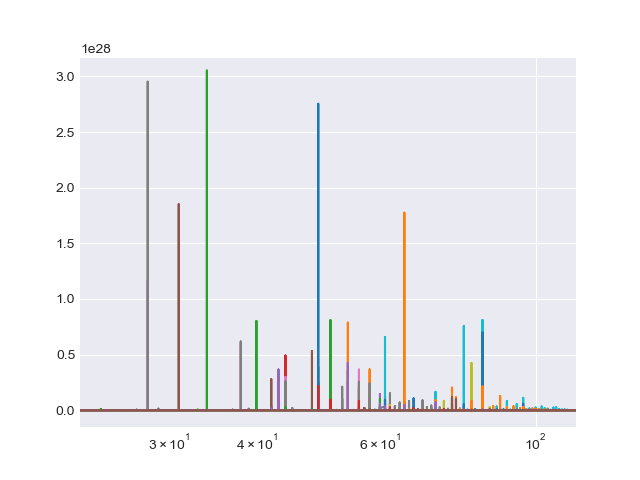

In [31]:

for key in data_files.keys():
    power_spec = np.abs(fft.rfft(data_files[key][1][index_keep]))**2
    cut_off = .5*np.max(power_spec)
    plt.plot(half_steps,power_spec )
    plt.plot(half_steps, cut_off, '--')
    plt.xscale('log')
plt.show()
